In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, FashionMNIST
from torch.utils.data import DataLoader

In [2]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

import pandas as pd
import seaborn as sn
import sklearn.metrics 
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms

from utils.eval_funcs import *
from utils.dataset_CIFAR100LT import *
from utils.network_arch_resnet import *
from utils.trainval import *
from utils.plot_funcs import *
import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.9.13 (main, Aug 25 2022, 23:26:10) 
[GCC 11.2.0]
2.0.1


In [3]:
# 定义深度卷积神经网络模型
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            #nn.Linear(64 * 16 * 16, 128),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.classifier1 = nn.Sequential(
            #nn.Linear(64 * 16 * 16, 128),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self.unknown_class = num_classes

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def open_set_forward(self, x, known_classes):
        x = self.features(x)
        #print(x.shape) 
        x = x.view(x.size(0), -1)
        #print(x.shape) 
        logits = self.classifier(x)

        # 计算每个样本的开放集得分
        open_scores = torch.softmax(logits[:, known_classes], dim=1)

        # 添加未知类别得分
        unknown_scores = torch.zeros(x.size(0), 1).to(x.device)
        open_scores = torch.cat((open_scores, unknown_scores), dim=1)

        return open_scores

In [4]:
# 设置随机种子和设备
torch.manual_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda


In [5]:
epoch_number=[]
loss_record=[]

In [6]:
class_number=[]
class_acc=[]
class_sample=[]

In [7]:
# 训练闭集模型
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_number.append(epoch)
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        loss_record.append(running_loss / len(train_loader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

In [8]:
# 测试开放集识别
def test(model, test_loader, known_classes):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            open_scores = model.open_set_forward(images, known_classes)
            _, predicted = torch.max(open_scores.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy}%")

In [9]:
# 数据预处理和加载器
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
'''

'\ntransform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Resize((32, 32)),\n    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\n])\n'

In [10]:

# Define the transformations for CIFAR10
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [11]:
# Define the transformations for MNIST
transform_mnist = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
'''
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_cifar)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
'''

"\ntrain_dataset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_cifar)\ntrain_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)\n"

In [13]:
# 加载CIFAR10测试集
testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform_cifar)
testloader = DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified


In [14]:
test_dataset = torchvision.datasets.FashionMNIST(root='data', train=False, download=True, transform=transform_mnist)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [15]:
import numpy as np
from torchvision import datasets

def build_long_tailed_dataset(dataset, imbalance_ratio):
    num_classes = len(dataset.classes)
    class_counts = np.zeros(num_classes, dtype=int)
    
    for _, label in dataset:
        class_counts[label] += 1
    
    max_class_count = class_counts.max()
    
    # Calculate the number of samples to keep for each class based on the imbalance ratio
    #num_samples_per_class = np.zeros(num_classes, dtype=int)
    total_num=50000
    imb_type = 'exp' # samling long-tailed training set with an exponetially-decaying function
    imb_factor = 0.002 # imbalance factor = 100 = 1/0.01
    num_samples_per_class = get_img_num_per_cls(100, total_num, imb_type, imb_factor)
    #for i, count in enumerate(class_counts):
        #num_samples_per_class[i] = int(max_class_count / (imbalance_ratio ** i))
        #num_samples_per_class[i] = int(max_class_count -imbalance_ratio **i)
    
    # Create a new dataset with imbalanced class distribution
    long_tailed_dataset = []
    
    for data, label in dataset:
        class_count = class_counts[label]
        num_samples = num_samples_per_class[label]
        
        if class_count <= num_samples:
            long_tailed_dataset.extend([(data, label)] * class_count)
        else:
            long_tailed_dataset.extend([(data, label)] * num_samples)
    
    return long_tailed_dataset

# Load the CIFAR-100 dataset
cifar100_train = datasets.CIFAR100(root='data', train=True, download=True, transform=transform_cifar)

# Build a long-tailed version of the CIFAR-100 dataset with imbalance ratio of 10
imbalance_ratio = 1.06

long_tailed_cifar100_train = build_long_tailed_dataset(cifar100_train, imbalance_ratio)

# Print the class distribution of the long-tailed dataset
class_counts = np.zeros(100, dtype=int)
for _, label in long_tailed_cifar100_train:
    class_counts[label] += 1

for i, count in enumerate(class_counts):
    print(f"Class {i}: {count} samples")
    class_number.append(i)
    class_sample.append(count)

Files already downloaded and verified
Class 0: 250000 samples
Class 1: 234500 samples
Class 2: 220500 samples
Class 3: 207000 samples
Class 4: 194000 samples
Class 5: 182500 samples
Class 6: 171500 samples
Class 7: 161000 samples
Class 8: 151000 samples
Class 9: 142000 samples
Class 10: 133000 samples
Class 11: 125000 samples
Class 12: 117500 samples
Class 13: 110500 samples
Class 14: 103500 samples
Class 15: 97500 samples
Class 16: 91500 samples
Class 17: 85500 samples
Class 18: 80500 samples
Class 19: 75500 samples
Class 20: 71000 samples
Class 21: 66500 samples
Class 22: 62500 samples
Class 23: 59000 samples
Class 24: 55000 samples
Class 25: 52000 samples
Class 26: 48500 samples
Class 27: 45500 samples
Class 28: 43000 samples
Class 29: 40000 samples
Class 30: 38000 samples
Class 31: 35500 samples
Class 32: 33500 samples
Class 33: 31000 samples
Class 34: 29500 samples
Class 35: 27500 samples
Class 36: 26000 samples
Class 37: 24500 samples
Class 38: 23000 samples
Class 39: 21500 sampl

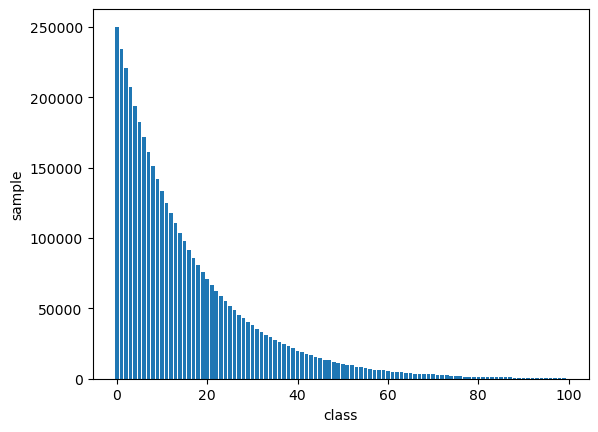

In [16]:
plt.xlabel('class')
plt.ylabel('sample')
#plt.title("The change of accuracy under different classess")
#plt.plot(class_number, class_acc, linewidth=2,  marker='.')
plt.bar(class_number, class_sample)
#plt.legend()
plt.show()